## Business Problem

### 1. Business Context
The objective of this project is to build a predictive model to understand and predict customer churn for a telecommunications company. Churn refers to the rate at which customers stop doing business with the company. Reducing churn is crucial for maintaining a strong customer base, optimizing revenue, and improving customer satisfaction.

### 2. Business Question
- **How can we predict which customers are likely to churn based on their usage data and interactions?**
- **Which features most significantly contribute to the likelihood of churn?**

### 3. Stakeholder Impact
**Why is this important?** Accurately predicting churn allows the company to take preemptive actions, such as personalized retention offers, targeted communication strategies, and service improvements, to retain valuable customers.

**Use Cases**:
- Implementing retention strategies based on churn predictions can help the company reduce the loss of customers, improve customer loyalty, and optimize marketing resources.


In [16]:
# Loading the Neccesary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score
from sklearn.model_selection import GridSearchCV

In [6]:
#Loading in the data
data = pd.read_csv('bigml_59c28831336c6604c800002a.csv')
data.head()

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


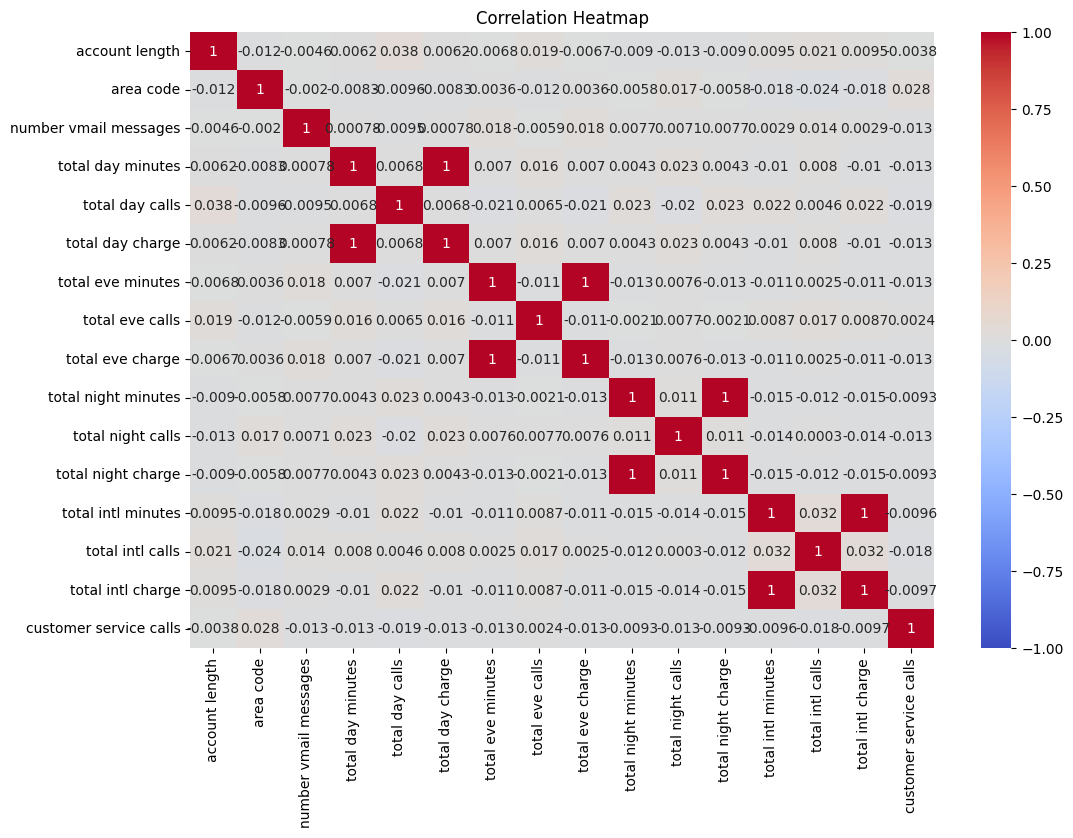

There is a strong positive correlation of 1.00 between 'total day charge' and 'total day minutes', indicating that as one increases, the other tends to increase as well.
There is a strong positive correlation of 1.00 between 'total day minutes' and 'total day charge', indicating that as one increases, the other tends to increase as well.
There is a strong positive correlation of 1.00 between 'total eve charge' and 'total eve minutes', indicating that as one increases, the other tends to increase as well.
There is a strong positive correlation of 1.00 between 'total eve minutes' and 'total eve charge', indicating that as one increases, the other tends to increase as well.
There is a strong positive correlation of 1.00 between 'total night charge' and 'total night minutes', indicating that as one increases, the other tends to increase as well.
There is a strong positive correlation of 1.00 between 'total night minutes' and 'total night charge', indicating that as one increases, the other

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Filter the DataFrame to include only numerical columns
numerical_data = data.select_dtypes(include=['number'])

# Calculate the correlation matrix
correlation_matrix = numerical_data.corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()

# Generate sentences based on the correlation matrix
threshold = 0.5  # Set a threshold for strong correlations

for col in correlation_matrix.columns:
    for index in correlation_matrix.index:
        if col != index and abs(correlation_matrix.loc[index, col]) > threshold:
            correlation_value = correlation_matrix.loc[index, col]
            if correlation_value > 0:
                print(f"There is a strong positive correlation of {correlation_value:.2f} between '{index}' and '{col}', indicating that as one increases, the other tends to increase as well.")
            else:
                print(f"There is a strong negative correlation of {correlation_value:.2f} between '{index}' and '{col}', suggesting that as one variable increases, the other tends to decrease.")


### Feature Selection Strategy

To address redundancy caused by perfect correlations between features (e.g., `total day charge` and `total day minutes`), the following strategy is recommended:

- **Keep only one feature from each highly correlated pair**:
  - Retain `total day minutes` and drop `total day charge`.
  - Retain `total eve minutes` and drop `total eve charge`.
  - Retain `total night minutes` and drop `total night charge`.
  - Retain `total intl minutes` and drop `total intl charge`.

### Key Features to Keep:
- `total day minutes`
- `total eve minutes`
- `total night minutes`
- `total intl minutes`
- Additional non-redundant features (e.g., `customer service calls`, `number vmail messages`).

### Rationale:
- **Avoid Redundancy**: Charges are directly proportional to minutes and do not add unique information.
- **Improve Model Stability**: Removing redundant features reduces multicollinearity and enhances model performance and interpretability.


In [9]:
# Identify the features and target variable
X = data[['total day minutes', 'total eve minutes', 'total night minutes', 'total intl minutes', 'customer service calls', 'number vmail messages']]
y = data['churn']

In [10]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [11]:
# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Build and Evaluate a Baseline Logistic Regression Model

In [14]:
# Create a logistic regression model
baseline_model = LogisticRegression(random_state=1)

#Fit the model on the training data
baseline_model.fit(X_train, y_train)

# Predict on the test data
y_pred = baseline_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, baseline_model.predict_proba(X_test)[:, 1])

print("Baseline Model Accuracy:", accuracy)
print("ROC AUC Score:", roc_auc)
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Baseline Model Accuracy: 0.853
ROC AUC Score: 0.7269207501512401
Classification Report:
               precision    recall  f1-score   support

       False       0.86      0.98      0.92       855
        True       0.47      0.10      0.16       145

    accuracy                           0.85      1000
   macro avg       0.67      0.54      0.54      1000
weighted avg       0.81      0.85      0.81      1000

Confusion Matrix:
 [[839  16]
 [131  14]]


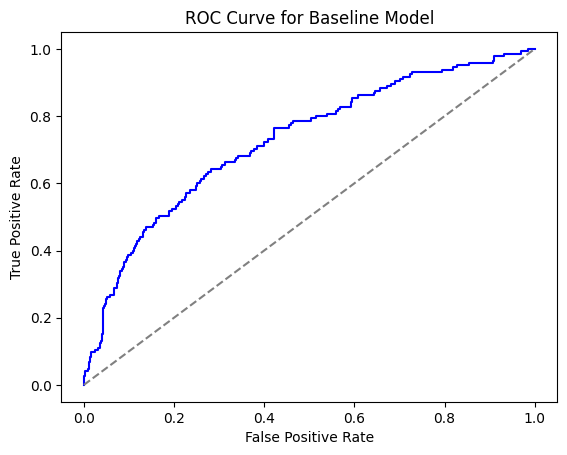

In [15]:
# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, baseline_model.predict_proba(X_test)[:, 1])
plt.plot(fpr, tpr, color='blue')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Baseline Model')
plt.show()

# Tune the Model with Hyperparameters

In [18]:
# Define parameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=LogisticRegression(random_state=1), param_grid=param_grid, cv=5, scoring='roc_auc')

# Fit grid search
grid_search.fit(X_train, y_train)

# Get the best estimator
best_model = grid_search.best_estimator_

In [20]:
# Evaluate the tuned model
y_pred_best = best_model.predict(X_test)
accuracy_best = accuracy_score(y_test, y_pred_best)
roc_auc_best = roc_auc_score(y_test, best_model.predict_proba(X_test)[:, 1])

print("Tuned Model Accuracy:", accuracy_best)
print("ROC AUC Score for Tuned Model:", roc_auc_best)
print("Classification Report for Tuned Model:\n", classification_report(y_test, y_pred_best))
print("Confusion Matrix for Tuned Model:\n", confusion_matrix(y_test, y_pred_best))

Tuned Model Accuracy: 0.854
ROC AUC Score for Tuned Model: 0.7273966525509175
Classification Report for Tuned Model:
               precision    recall  f1-score   support

       False       0.86      0.98      0.92       855
        True       0.48      0.09      0.15       145

    accuracy                           0.85      1000
   macro avg       0.67      0.54      0.54      1000
weighted avg       0.81      0.85      0.81      1000

Confusion Matrix for Tuned Model:
 [[841  14]
 [132  13]]


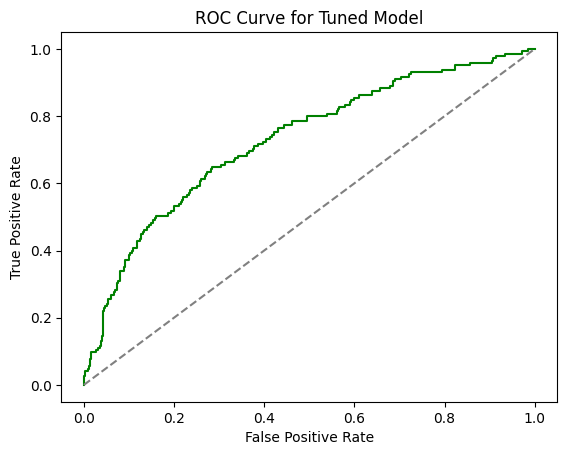

In [21]:
# Plot ROC curve for the tuned model
fpr, tpr, _ = roc_curve(y_test, best_model.predict_proba(X_test)[:, 1])
plt.plot(fpr, tpr, color='green')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Tuned Model')
plt.show()

## Step 4: Final Model Discussion

### Interpretability
- The coefficients of the logistic regression model reveal the impact of each feature on predicting churn.
- **Key Insight**: Features with larger absolute coefficient values contribute more significantly to churn prediction.

### Business Implications
- The model results provide actionable insights for stakeholders by highlighting features that influence churn the most.
- Example Applications:
  - Addressing factors like frequent customer service calls.
  - Optimizing call plans for day and night usage patterns.

### Recommendations
- **Predictive Actions**: Use the model to identify customers at high risk of churn.
- **Retention Strategies**: Deploy targeted interventions, such as personalized offers, improved service, and better communication, to retain these customers.
